In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
from copy import deepcopy
from collections import Counter

In [3]:
from nltk.tokenize import sent_tokenize

In [4]:
from nltk.tokenize import TreebankWordTokenizer

In [5]:
from nltk.tag import pos_tag

In [267]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD

from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix

from sklearn.cluster import KMeans

**ORIGINAL DATA SET CAN BE FOUND HERE:**

[Kaggle Fake News Dataset](https://www.kaggle.com/mrisdal/fake-news/downloads/fake-news.zip)

In [6]:
zipfile_path = '/home/farhaan/Downloads/fake-news.zip'
df_fakenews = pd.read_csv(zipfile_path,compression="zip")

In [7]:
df_fakenews.head(3)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


In [8]:
list(df_fakenews.loc[:,'text'].sample(1))

["Turkey, Syria & Russia proving cooperation possible - Yasar Yakis, ex-Turkish FM Published time: 26 Oct, 2016 17:36 Edited time: 26 Oct, 2016 17:37 Get short URL Former Turkish Foreign Minister Yasar Yakis at the 13th annual meeting of the Valdai International Discussion Club in Sochi © Nina Zotina / Sputnik Journalists, politicians and academicians have descended upon the Russian Black Sea resort of Sochi for the 13th annual Valdai International Discussion Club at a time of deepening political fractures between Russia and the West. \nRT spoke on the sidelines of the event with Yasar Yakis, former Foreign Minister of Turkey, for his opinion on a wide range of issues, including Russian sanctions and the ongoing Syrian conflict, which has driven a wedge between Russia and the US-led coalition. \nLater in this section, RT also talks with Wolfgang Schussel, former Federal Chancellor of the Republic of Austria (2000-2007). Russia not to blame for Ukraine crisis and sanctions won't work (O

In [9]:
df_fakenews.shape

(12999, 20)

In [10]:
df_fakenews['type'].value_counts()

bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64

In [11]:
str_lengths = df_fakenews.text.str.len()
len(str_lengths[str_lengths>1000])

9933

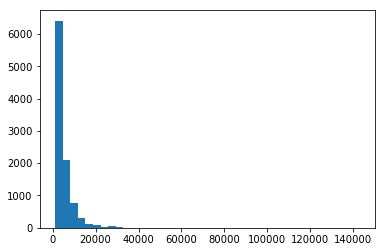

In [12]:
plt.hist(str_lengths[str_lengths>1000],bins=40);

## Filtered fakenews dataframe

In [211]:
fakenews_df_filtered = df_fakenews[pd.notnull(df_fakenews['text'])]
fakenews_df_filtered = fakenews_df_filtered[fakenews_df_filtered['language']=='english']
delregex1= re.compile('(?:Be the First to Comment.*articles *$|Subscribe *$|\nRelated:.*$| Share:.*$)',re.IGNORECASE|re.DOTALL)
delregex2 = re.compile('(?:Submit your review|Follow on (?:Facebook|Twitter)|Print this post|Share on (?:Facebook|Twitter))',re.IGNORECASE)
delregex3 = re.compile('(?:Century Wire|Newsinfo|Delivered by The Daily Sheeple\nWe .*$|barracuda brigade)',re.IGNORECASE)
delregex4 = re.compile('READ MORE ELECTION NEWS AT .*$',re.IGNORECASE,re.DOTALL)
delregex5 = re.compile('^.{0,300}Leave a Comment |Leave a Reply Click here to get more.*',re.IGNORECASE|re.DOTALL)
delregex6 = re.compile('(?:SUBSCRIBE on YouTube|[\n\.].*?like and share .*|^Share on Twitter.*\.|This article was written by .*?\.)',re.IGNORECASE)
# delregex7 = re.compile('\nRelated:.*$',re.IGNORECASE|re.DOTALL)
# delregex8 = re.compile('Subscribe *$',re.IGNORECASE)
for ind,txt in zip(fakenews_df_filtered.index,fakenews_df_filtered.text):
    txt = re.sub(delregex1,"",txt)
    txt = re.sub(delregex2,"",txt)
    txt = re.sub(delregex3,"",txt)
    txt = re.sub(delregex4,"",txt)
    txt = re.sub(delregex5,"",txt)
    txt = re.sub(delregex6,"",txt)
    

#     txt = re.sub(delregex7,"",txt)
#     txt = re.sub(delregex8,"",txt)
    fakenews_df_filtered.set_value(ind,'text',txt)
fakenews_df_filtered = fakenews_df_filtered[fakenews_df_filtered.text.str.len()>850]
text= fakenews_df_filtered.text

In [212]:
len(fakenews_df_filtered)

9692

In [209]:
state = 30
index1 = fakenews_df_filtered.sample(random_state=state).index
print(list(fakenews_df_filtered.sample(random_state=state).index),'\n',list(fakenews_df_filtered.sample(random_state=state).text))

[8857] 
 ['Thu, 27 Oct 2016 15:29 UTC The United States has called for a special meeting with Russia over alleged violations of the 1987 Intermediate-range Nuclear Forces (INF) treaty - a landmark Cold War-era agreement. Washington wants the Special Verification Commission (SVC) to discuss the problems related to the treaty\'s compliance . The event is expected to take place in mid-November. The INF set up the Special Verification Commission as a way to deal with disputes surrounding the treaty. Ukraine, Belarus and Kazakhstan can also attend the meeting because they housed intermediate range missiles before the disintegration of the Soviet Union and remain parties to the treaty. No SVC meeting has been convened since 2003. Russia welcomes the United States\' offer. «We have responded positively», said Mikhail Ulyanov, the head of Foreign Ministry\'s Non-Proliferation and Arms Control Department. The treaty, which bans testing, producing, and possessing ground-launched ballistic and cr

In [210]:
list(df_fakenews.iloc[index1,5])

['Thu, 27 Oct 2016 15:29 UTC The United States has called for a special meeting with Russia over alleged violations of the 1987 Intermediate-range Nuclear Forces (INF) treaty - a landmark Cold War-era agreement. Washington wants the Special Verification Commission (SVC) to discuss the problems related to the treaty\'s compliance . The event is expected to take place in mid-November. The INF set up the Special Verification Commission as a way to deal with disputes surrounding the treaty. Ukraine, Belarus and Kazakhstan can also attend the meeting because they housed intermediate range missiles before the disintegration of the Soviet Union and remain parties to the treaty. No SVC meeting has been convened since 2003. Russia welcomes the United States\' offer. «We have responded positively», said Mikhail Ulyanov, the head of Foreign Ministry\'s Non-Proliferation and Arms Control Department. The treaty, which bans testing, producing, and possessing ground-launched ballistic and cruise miss

## Count vectorizer and PCA, straight up 

In [222]:
vectorizer = CountVectorizer(strip_accents='ascii',analyzer='word',lowercase=True,stop_words='english',min_df=10)

In [223]:
vectorizer.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [224]:
# print(vectorizer.get_feature_names())

In [225]:
len(vectorizer.get_feature_names())

21801

In [226]:
feat_names_dirty = vectorizer.get_feature_names()

In [227]:
regex='[^\d_]*'
feat_names_clean= [re.findall(regex,s)[0] for s in feat_names_dirty if (re.findall(regex,s)!=[] and len(re.findall(regex,s)[0])>=4 and len(re.findall(regex,s)[0])<20)]

feat_names_clean= list(set(feat_names_clean))

In [228]:
# [w for w in feat_names_dirty if len(w)>=20]

In [229]:
Counter([len(i) for i in feat_names_clean])

Counter({4: 1590,
         5: 2402,
         6: 3007,
         7: 3326,
         8: 3084,
         9: 2568,
         10: 1906,
         11: 1199,
         12: 720,
         13: 369,
         14: 170,
         15: 68,
         16: 29,
         17: 15,
         18: 6,
         19: 2})

In [230]:
# print(feat_names_clean)

In [231]:
len(feat_names_clean)

20461

In [232]:
vectorizer = CountVectorizer(vocabulary=feat_names_clean)

In [233]:
vectorizer.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=['subsequently', 'handbook', 'romania', 'alleged', 'carriers', 'confirm', 'grips', 'swathes', 'burkhart', 'reigniting', 'unruh', 'foreseeable', 'profile', 'govern', 'chopping', 'residency', 'tactic', 'internally', 'ranchers', 'prism', 'warped', 'roofs', 'seed', 'understood', 'underestimat... 'expands', 'tentatively', 'illegal', 'impromptu', 'tubes', 'forceful', 'predisposed', 'appointees'])

In [234]:
print(vectorizer.get_feature_names())

['subsequently', 'handbook', 'romania', 'alleged', 'carriers', 'confirm', 'grips', 'swathes', 'burkhart', 'reigniting', 'unruh', 'foreseeable', 'profile', 'govern', 'chopping', 'residency', 'tactic', 'internally', 'ranchers', 'prism', 'warped', 'roofs', 'seed', 'understood', 'underestimating', 'pharmacy', 'reunification', 'pretext', 'jill', 'topics', 'feverishly', 'attorney', 'insect', 'distancing', 'epsteins', 'amended', 'unilateral', 'wrecked', 'projecting', 'remnants', 'canyon', 'device', 'corrupting', 'controlling', 'bureaucrat', 'shiny', 'compound', 'fairy', 'retribution', 'term', 'subordinate', 'litmus', 'cartoon', 'accredited', 'amazon', 'carnage', 'coca', 'cracked', 'deterrent', 'menu', 'princes', 'denomination', 'intervals', 'lynch', 'pressure', 'tribute', 'cholesterol', 'passive', 'wellness', 'simplistic', 'unpopular', 'east', 'proxy', 'pussy', 'snowden', 'idiocy', 'schwerin', 'unattended', 'contrasts', 'development', 'unipolar', 'warlords', 'addressing', 'soross', 'crackdown

In [235]:
wd_frequency = vectorizer.transform(text)

In [ ]:
u,s,vt = svds(wd_frequency.asfptype(),k=200)

In [ ]:
u.shape

In [ ]:
s

In [ ]:
cumul=0
n_components=[]
cum_vals = []
for ind,singv in enumerate(sorted(s,reverse=True)):
    cumul += singv
    n_components.append(ind)
    cum_vals.append(cumul/sum(s))

In [ ]:
plt.plot(n_components,cum_vals,'g-')

In [ ]:
tsvd = TruncatedSVD(n_components=300,random_state=40)

In [ ]:
tsvd.fit(wd_frequency)

In [ ]:
tsvd.get_params()

In [ ]:
sum(tsvd.explained_variance_ratio_)

In [ ]:


cumul=0
n_components=[]
cum_vals = []
for ind,singv in enumerate(tsvd.explained_variance_ratio_):
    cumul += singv
    n_components.append(ind+1)
    cum_vals.append(cumul)
    
plt.plot(n_components,cum_vals,'g-');

In [ ]:
transformed_wd_frequency = pd.DataFrame(tsvd.transform(wd_frequency))

In [ ]:
kmeanscl = KMeans(n_clusters=10,n_jobs=-1,random_state=40)

kmeanscl.fit(transformed_wd_frequency)

centroids = kmeanscl.cluster_centers_

Counter(kmeanscl.labels_)

In [ ]:
len(kmeanscl.labels_)

In [ ]:
clustered_text = pd.merge(pd.DataFrame(fakenews_df_filtered),
                          pd.DataFrame(kmeanscl.labels_,
                                       index=fakenews_df_filtered.index,
                                       columns=['cluster_label']),
                          how='left',left_index=True,right_index=True)

In [ ]:
list(clustered_text[clustered_text['cluster_label']==4]['text'].sample())

In [ ]:
clustered_text[clustered_text['language']!='english']

In [ ]:
clustered_text[clustered_text['cluster_label']==8]

In [ ]:
[list(print(doc,'\n\n') for doc in clustered_text[clustered_text['cluster_label']==2].sample(5).text)]

## TFIDF

In [264]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(strip_accents='ascii',analyzer='word',lowercase=True,stop_words='english',min_df=10,vocabulary=feat_names_clean)

In [ ]:
vectorizer.fit(text)

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
wd_frequency = vectorizer.transform(text)
tsvd = TruncatedSVD(n_components=300,random_state=40)
tsvd.fit(wd_frequency)

In [ ]:
cumul=0
n_components=[]
cum_vals = []
for ind,singv in enumerate(tsvd.explained_variance_ratio_):
    cumul += singv
    n_components.append(ind+1)
    cum_vals.append(cumul)
    
plt.plot(n_components,cum_vals,'g-');

In [ ]:
sorted([(ind,val) for ind,val in enumerate(tsvd.components_[0])],key=lambda x: x[1],reverse=True)[:10]

In [ ]:
test_indices = [10187,10824,2465,10654,3326,11731]
[feat_names_clean[i] for i in test_indices]

In [ ]:
transformed_wd_frequency = pd.DataFrame(tsvd.transform(wd_frequency))

In [ ]:
kmeanscl = KMeans(n_clusters=10,n_jobs=-1,random_state=40)

kmeanscl.fit(transformed_wd_frequency)

centroids = kmeanscl.cluster_centers_

Counter(kmeanscl.labels_)

In [ ]:
sorted([(ind,val) for ind,val in enumerate(centroids[9])],key=lambda x: x[1],reverse=True)

In [ ]:
centroids[0]

In [ ]:
# to get the most important topics in the cluster:
for cluster_ind in range(len(centroids)):
    main_topics_in_cluster = [topic[0] for topic in sorted([(ind,val) for ind,val in enumerate(centroids[cluster_ind])],key=lambda x: x[1],reverse=True)[:3]]
    topic_relative_importance = [topic[1] for topic in sorted([(ind,val) for ind,val in enumerate(centroids[cluster_ind])],key=lambda x: x[1],reverse=True)[:3]]
    print(f"Cluster # {cluster_ind}",main_topics_in_cluster)
    print(f"Topic rel. importance: {np.around(topic_relative_importance,3)}\n")
    for topic in main_topics_in_cluster:
        words_in_topic = [word_ind[0] for word_ind in sorted([(ind,val) for ind,val in enumerate(tsvd.components_[topic])],key=lambda x: x[1],reverse=True)[:15]]
        print(f"Topic # {topic}",[feat_names_clean[word_ind] for word_ind in words_in_topic])
    excerpts = [clustered_text[clustered_text['cluster_label']==cluster_ind].loc[:,'text'].iloc[i][200:600] for i in range(5,8)]
    for ind,excerpt in enumerate(excerpts):
        print(f"\n*******Excerpt#{ind+1}: *********\n {excerpt}")
    print('\n\n')
    print("___________________________________________________________________________")

In [ ]:
clustered_text = pd.merge(pd.DataFrame(fakenews_df_filtered),
                          pd.DataFrame(kmeanscl.labels_,
                                       index=fakenews_df_filtered.index,
                                       columns=['cluster_label']),
                          how='left',left_index=True,right_index=True)

In [ ]:
list(clustered_text[clustered_text['cluster_label']==9].loc[:,'text'].iloc[i][300:1000] for i in range(10))

# SPACY

In [213]:
import spacy

In [214]:
nlp = spacy.load('en')

In [256]:
mod_text = deepcopy(text)

In [261]:
cleanText(mod_text[1])

'why did attorney general loretta lynch plead the fifth? barracuda brigade -- print the administration is blocking congressional probe into cash payments to iran. of course she needs to plead the . she either can t recall, refuses to answer, or just plain deflects the question. straight up corruption at its finest!   ; talk about covering your ass! loretta lynch did just that when she plead the fifth to avoid incriminating herself over payments to iran…corrupt to the core! attorney general loretta lynch is declining to comply with an investigation by leading members of congress about the obama administration s secret efforts to send iran $ billion in cash earlier this year, prompting accusations that lynch has “pleaded the fifth” amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the washington free beacon.  sen. marco rubio (r., fla.) and rep. mike pompeo (r., kan.) initially presented lynch in october with a

In [263]:
mod_docs = [doc for doc in nlp.pipe(mod_text,n_threads=3)]

In [218]:
doc_idxs = [doc_idx for doc_idx in text.index]

In [220]:
documents = [nlp(doc) for doc in text]

In [217]:
text

1        Why Did Attorney General Loretta Lynch Plead T...
2        Red State : \nFox News Sunday reported this mo...
4        Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...
5        Print Hillary goes absolutely berserk! She exp...
6        BREAKING! NYPD Ready To Make Arrests In Weiner...
7        BREAKING! NYPD Ready To Make Arrests In Weiner...
8        \nLimbaugh said that the revelations in the Wi...
11       \nWho? Comedian. \nWhere would she move? Spain...
12       Students expressed their “fear” over a Trump p...
13       Email For Republican politicians like Ohio Gov...
17       Go to Article Donald Trump was willing to give...
18       John McNaughton is a special American painter ...
19       Go to Article Dear Abby, I supported a woman I...
20       Mark Cuban has made no secret of his dislike f...
23       Go to Article \nPolitical activist and Hillary...
26       Go to Article \nThey had to know they had it c...
27       DONALD TRUMP SKIPS MEDIA: Delivers Transition .

In [ ]:
ttxt = clustered_text[clustered_text['cluster_label']==4].text[10337]

In [ ]:
ttxt

In [239]:
documents[14]

Go to Article 
Political activist and Hillary supporter Amal Clooney traveled to Texas to warn Americans about our elected President Donald J. Trump and his tough immigration policies. Maybe she didn’t get the memo…Trump’s tough immigration stance is what catapulted him to the top of the heap in the crowded pack of GOP primary contenders. It wasn’t too long ago that her arrogant liberal husband announced with great confidence, “There will never be a President Trump”. 
Perhaps Amal should’ve traveled to some of the border towns if she wanted to get a clear picture of how illegal immigration is affecting our nation. Aliens crossing our borders illegally have destroyed the property of American ranchers, and threatened the safety and security of American citizens living in homes in or near the US -Mexican border towns… 
Amal Clooney has warned that many of president-elect Trump’s proposals would be ‘violations of international law.’ 
Speaking at the Texas Conference For Women at the Austin

In [247]:
for token in documents[3]:
    print(token.lemma_)

print
hillary
go
absolutely
berserk
!
-PRON-
explode
on
bill
'
rapist’
protester
at
rally
…
oh
the
irony
!
-PRON-
be
an
enabler
to
bill
’s
"
escapade
"
.
-PRON-
’s
be
just
project
again
.
-PRON-
be
so
pathetic
.
drag
integrity
challenge
alicia
machado
on
stage
with
-PRON-
yesterday
at
-PRON-
sad
little
"
rally
"
in
florida
.


tgp
:
democratic
party
presidential
nominee
hillary
clinton
angrily
react
to
a
protester
shout
"
bill
clinton
be
a
rapist
"
at
a
campaign
rally
in
fort
lauderdale
,
florida
tuesday
night
,
say
,
"
-PRON-
be
sick
and
tired
of
the
negative
,
dark
,
divisive
,
dangerous
vision
and
behavior
of
people
who
support
donald
trump
,
"
accord
to
report
.


protester
interrupt
hillary
clinton
shout
"
bill
clinton
be
a
rapist
.
"
clinton
fire
right
back
"
-PRON-
be
sick
and
tired
of
the
negative
"
pic.twitter.com/yncdks90bg


--
josh
haskell
(
@joshbhaskell
)
november
2
,
2016
man
interrupt
@hillaryclinton
yell
"
bill
clinton
be
a
rapist"-
-PRON-
respond
-PRON-
be
tired
of
di

In [ ]:

stw = list(stopwords.words('english'))
stw +=['.',',','!','?','"',"'"]

In [ ]:
string.punctuation

In [248]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string

In [268]:
# A custom stoplist
content_specific_stopwords = ['trump', 'clinton', 'hillary', 'election', 'people', 'said', 'president', 'obama', 'campaign']
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca","’s","'ve"] + list(ENGLISH_STOP_WORDS)+content_specific_stopwords)
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---",'--','-', "...", "“", "”",'…' ,'’','–']

# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
    
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # split up words comlicated by some symbols
    text = text.replace('’'," ")
    
    #convert text to unicode
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) # no emoji
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("", text)
    
    # replace HTML symbols
    bracs_regex = re.compile('<.*?>')
    text = re.sub(bracs_regex," ",text)
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # delete urls
    url_reg = re.compile('\w+(?:\.\w+)+')
    text = re.sub(url_reg, "", text)
    url_reg2 = re.compile('http.* ')
    text = re.sub(url_reg2, " ", text)
    
    # delete words countaining numbers
    num_reg = re.compile('\w*\d+\w*')
    text = re.sub(num_reg, "", text)
        
    # lowercase
    text = text.lower()
    
    # only return alphabetical words
    letter_reg = re.compile(' .*[^a-z]+?.* ')
    text = re.sub(letter_reg,' ',text)

    return text

# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = nlp(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    tokens = [token for token in tokens if len(token)>=3]
    return tokens

def printNMostInformative(vectorizer, clf, N):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)
    
# the vectorizer and classifer to use
# note that I changed the tokenizer in CountVectorizer to use a custom function using spaCy's tokenizer
vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))
clf =  KMeans(n_clusters=10,n_jobs=-1,random_state=40)
# the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

In [276]:
cl_text_tf = CleanTextTransformer()

In [277]:
cl_text_tf.fit(mod_text)

In [279]:
cl_txt = cl_text_tf.transform(mod_text)

In [281]:
cl_txt[0]

'why did attorney general loretta lynch plead the fifth? barracuda brigade -- print the administration is blocking congressional probe into cash payments to iran. of course she needs to plead the . she either can t recall, refuses to answer, or just plain deflects the question. straight up corruption at its finest!   ; talk about covering your ass! loretta lynch did just that when she plead the fifth to avoid incriminating herself over payments to iran…corrupt to the core! attorney general loretta lynch is declining to comply with an investigation by leading members of congress about the obama administration s secret efforts to send iran $ billion in cash earlier this year, prompting accusations that lynch has “pleaded the fifth” amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the washington free beacon.  sen. marco rubio (r., fla.) and rep. mike pompeo (r., kan.) initially presented lynch in october with a

In [282]:
vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))

In [283]:
vectorizer.fit(cl_txt)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeText at 0x7fdc3330ab70>, use_idf=True,
        vocabulary=None)

In [284]:
sparsed_txt = vectorizer.transform(cl_txt)

In [294]:
vectorizer.get_feature_names()

['"--',
 '"></span',
 '"full',
 '"here',
 '"hot',
 "'cause",
 "'em",
 "'ll",
 '(-;',
 '(proverb',
 '(russia',
 '(so',
 '(they',
 ')as',
 ')instead',
 '-(-phenylethyl',
 '-(a',
 '-(e',
 '--"these',
 '--(g',
 '----',
 '--/',
 '--::-',
 '--a',
 '--ad',
 '--and',
 '--as',
 '--at',
 '--but',
 '--civ',
 '--even',
 '--ha',
 '--he',
 '--image',
 '--is',
 '--it\x92s',
 '--it\x92s--',
 '--leader',
 '--million',
 '--once',
 '--our',
 '--remy',
 '--say',
 '--the',
 '--what',
 '--whatever',
 '--what\x92s',
 '--when',
 '--which',
 '--would',
 '-/-dimensional',
 '-/-month',
 '-/s',
 '-;margin',
 '-abraham',
 '-acre',
 '-affiliat',
 '-after',
 '-against-',
 '-all',
 '-alt',
 '-america',
 '-an',
 '-and',
 '-anti',
 '-as',
 '-at',
 '-athaliah',
 '-austin',
 '-automatic',
 '-ballot',
 '-bank',
 '-barack',
 '-barrel',
 '-bed',
 '-bedroom',
 '-believ',
 '-bestsell',
 '-beyond',
 '-bigelow',
 '-bill',
 '-billion',
 '-bit',
 '-blade',
 '-blind',
 '-block',
 '-bloomberg',
 '-born',
 '-brain',
 '-brutal',
 '-b

In [285]:
type(sparsed_txt)

scipy.sparse.csr.csr_matrix

In [290]:
tsvd = TruncatedSVD(n_components=80,random_state=40)
tsvd.fit(sparsed_txt)

TruncatedSVD(algorithm='randomized', n_components=80, n_iter=5,
       random_state=40, tol=0.0)

In [291]:
sum(sorted(tsvd.explained_variance_ratio_))

0.16417349872448042

In [292]:
kmeanscl = KMeans(n_clusters=8,n_jobs=-1,random_state=40)

transformed_wd_frequency = pd.DataFrame(tsvd.transform(sparsed_txt))

kmeanscl.fit(transformed_wd_frequency)

centroids = kmeanscl.cluster_centers_

Counter(kmeanscl.labels_)

Counter({0: 479, 1: 1474, 2: 598, 3: 5032, 4: 511, 5: 529, 6: 894, 7: 175})

In [269]:
# data
train = mod_text

# train
pipe.fit(train)

KeyboardInterrupt: 

In [262]:
for sent in list(documents[0].sents)[:10]:
    for token in sent:
        print(token.lemma_)

why
do
attorney
general
loretta
lynch
plead
the
fifth
?
barracuda
brigade
2016
-
10
-
28
print
the
administration
be
block
congressional
probe
into
cash
payment
to
iran
.
of
course
-PRON-
need
to
plead
the
5th
.
-PRON-
either
can
not
recall
,
refuse
to
answer
,
or
just
plain
deflect
the
question
.
straight
up
corruption
at
-PRON-
fine
!


100percentfedup.com
;
talk
about
cover
-PRON-
ass
!
loretta
lynch
do
just
that
when
-PRON-
plead
the
fifth
to
avoid
incriminate
-PRON-
over
payment
to
iran
…
corrupt
to
the
core
!
attorney
general
loretta
lynch
be
decline
to
comply
with
an
investigation
by
lead
member
of
congress
about
the
obama
administration
’s
secret
effort
to
send
iran
$
1.7
billion
in
cash
earlier
this
year
,
prompt
accusation
that
lynch
have
"
plead
the
fifth
”
amendment
to
avoid
incriminate
-PRON-
over
these
payment
,
accord
to
lawmaker
and
communication
exclusively
obtain
by
the
washington
free
beacon
.


sen.
marco
rubio
(
r.
,
fla.
)
and
rep.
mike
pompeo
(
r.
,
kan.
)
initia

In [ ]:
len(text)

In [ ]:
from spacy.en import English
parser = English()

In [ ]:
testtoklist = cleanText(text[5])

In [ ]:
type(testtoklist[0])

In [ ]:
tst2=deepcopy(text[5])

In [ ]:
regex = re.compile('\w+(?:\.\w+)+')

In [ ]:
re.findall(regex,tst2)

In [ ]:
list(ENGLISH_STOP_WORDS)

In [ ]:
fakenews_df_filtered

In [ ]:
mod_text = deepcopy(text)

In [240]:
import gensim

In [244]:
from gensim import corpora, models, similarities

In [246]:
tfidf = models.TfidfModel(documents[0])

TypeError: 'spacy.tokens.token.Token' object is not iterable